In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.6 MB/s eta 0:00:00


In [ ]:
import rasterio
import torch
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import os
import shutil
import random
from google.colab import drive
import sys
import time
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

In [ ]:

#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#path = '/content/drive/MyDrive/Academico/Computer Vision'
#sys.path.append(path)
base_dir = os.getcwd()


In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def determine_max_pixel_value(data):
    max_value = 0
    for item in data:
        image = Image.open(item['image_path'])
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_np = np.array(image)
        max_value = max(max_value, image_np.max())
    return max_value

In [ ]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from torchvision import transforms

# Function to load data from JSON file
def load_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def scale_and_normalize_image(image, max_value):
    image = np.array(image).astype(np.float32)
    image = (image / image.max()) * 255
    return image/max_value

class TiffDataset(Dataset):
    def __init__(self, data, transform=None, max_value = 255.0):
        self.data = data
        self.transform = transform
        self.max_value = max_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path'])

        # Convert to RGB if necessary
        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = scale_and_normalize_image(image, self.max_value)

        if self.transform:
            image = self.transform(image)

        label = item['label']
        return image, label

# Load data from JSON files
train_json_file = base_dir + '/Data/Train_80_enhanced.json'
test_json_file = base_dir + '/Data/Test_20_enhanced.json'
train_data = load_data(train_json_file)
test_data = load_data(test_json_file)

train_data = load_data(train_json_file)
test_data = load_data(test_json_file)

#max_pixel_value = determine_max_pixel_value(train_data)
max_pixel_value = 255.0
# Define transformations


transform_tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=180),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),






])


transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))

])

# Determine the max pixel value from the training dataset for normalization

# Create datasets
train_dataset = TiffDataset(train_data, transform=transform_tr, max_value=max_pixel_value)
test_dataset = TiffDataset(test_data, transform=transform_val, max_value=max_pixel_value)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Epoch 0/99, Loss: 0.5180, Accuracy: 0.7630, Time: 284.44s
Validation Loss: 0.5162, Accuracy: 0.7475
Epoch 1/99, Loss: 0.4465, Accuracy: 0.7854, Time: 4.20s
Validation Loss: 0.4302, Accuracy: 0.8045
Epoch 2/99, Loss: 0.4218, Accuracy: 0.8065, Time: 4.42s
Validation Loss: 0.4169, Accuracy: 0.8292
Epoch 3/99, Loss: 0.3971, Accuracy: 0.8189, Time: 4.26s
Validation Loss: 0.6707, Accuracy: 0.7277
Epoch 4/99, Loss: 0.4123, Accuracy: 0.8033, Time: 4.39s
Validation Loss: 0.4148, Accuracy: 0.8342
Epoch 5/99, Loss: 0.4042, Accuracy: 0.8213, Time: 4.21s
Validation Loss: 0.4693, Accuracy: 0.8317
Epoch 6/99, Loss: 0.4028, Accuracy: 0.8040, Time: 4.24s
Validation Loss: 0.4062, Accuracy: 0.8168
Epoch 7/99, Loss: 0.3733, Accuracy: 0.8406, Time: 4.39s
Validation Loss: 0.4559, Accuracy: 0.7946
Epoch 8/99, Loss: 0.3791, Accuracy: 0.8207, Time: 4.20s
Validation Loss: 0.4118, Accuracy: 0.8267
Epoch 9/99, Loss: 0.3799, Accuracy: 0.8269, Time: 4.34s
Validation Loss: 0.3826, Accuracy: 0.8391
Epoch 10/99, Loss:

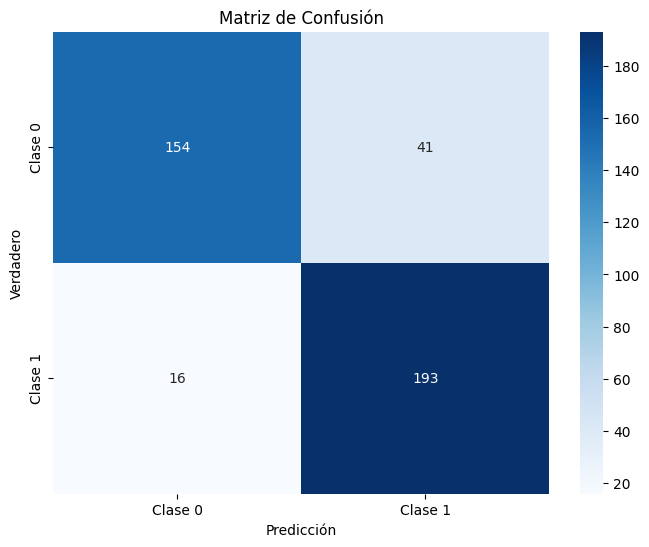

In [ ]:
import torch.nn as nn
import torch.optim as optim
import time

model = models.resnet50(weights="DEFAULT")
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) #Drop to 0.0001 after 50 epochs

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=100):
    best_acc = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {elapsed_time:.2f}s")

        # Validate the model
        model.eval()
        val_loss = 0.0
        corrects = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())


        val_loss /= len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            best_all_labels = all_labels
            best_all_preds = all_preds

    model.load_state_dict(best_model_wts)


    torch.save(model.state_dict(), base_dir +  '/Redes_entrenadas/Resnet50_enhanced_fp.pth')
    print('Model saved with accuracy: {:.4f}'.format(best_acc))

    cm = confusion_matrix(best_all_labels, best_all_preds)
    cr = classification_report(best_all_labels, best_all_preds)
    accuracy = (np.array(best_all_preds) == np.array(best_all_labels)).mean()
    print("Matriz de Confusión:")
    print(cm)
    print("Reporte de Clasificación:")
    print(cr)
    print(f"Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title('Matriz de Confusión')
    plt.show()

# Train the model
train_model(model, criterion, optimizer, train_loader, test_loader, scheduler, num_epochs=100)
